# Basic Wave Equation
$$\frac{\partial^2 u}{\partial t^2} = c^2\frac{\partial^2 u}{\partial x^2}$$

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def rk4_step(state, f, dt, *args):
    '''
    state: a tuple that include all nodes of each variable.
    f: the specific expression of the equation, the expression of the time derivative.
    dt: time step
    '''

    # k1
    k1 = f(state, *args)
    # add dt/2*k1 to each component of state
    state_k1 = tuple(s + 0.5 * dt * k for s, k in zip(state, k1))

    # k2
    k2 = f(state_k1, *args)
    # add dt/2*k2 to each component of state
    state_k2 = tuple(s + 0.5 * dt * k for s, k in zip(state, k2))

    # k3
    k3 = f(state_k2, *args)
    # add dt * k3 to each component of state
    state_k3 = tuple(s + dt* k for s, k in zip(state, k3))

    # k4
    k4 = f(state_k3, *args)

    # update
    new_state = tuple(
        s + (dt/6.0) * (k1_i + 2*k2_i + 2*k3_i + k4_i)
        for s, k1_i, k2_i, k3_i, k4_i in zip(state, k1, k2, k3, k4)
    )

    return new_state

def wave_equation(state, c, dx):
    u, v = state
    N = len(u) - 1

    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(v)

    for i in range(1, N):
        du_dt[i] = v[i]
        dv_dt[i] = c**2 * (u[i+1] - 2*u[i] + u[i-1]) / dx**2

    # Fixed boundary condition
    # du_dt[0] = 0.0
    # dv_dt[0] = 0.0
    # du_dt[N] = 0.0
    # dv_dt[N] = 0.0

    # Periodic boundary condition
    # du_dt[0] = v[0]
    # dv_dt[0] = c**2 * (u[1] - 2*u[0] + u[N]) / dx**2

    # du_dt[N] = v[N]
    # dv_dt[N] = c**2 * (u[0] - 2*u[N] + u[N-1]) / dx**2

    # No boundary condition
    du_dt[0] = v[0]
    dv_dt[0] = c**2 * (u[1] - u[0]) / dx**2

    du_dt[N] = v[N]
    dv_dt[N] = c**2 * (- u[N] + u[N-1]) / dx**2

    return (du_dt, dv_dt)

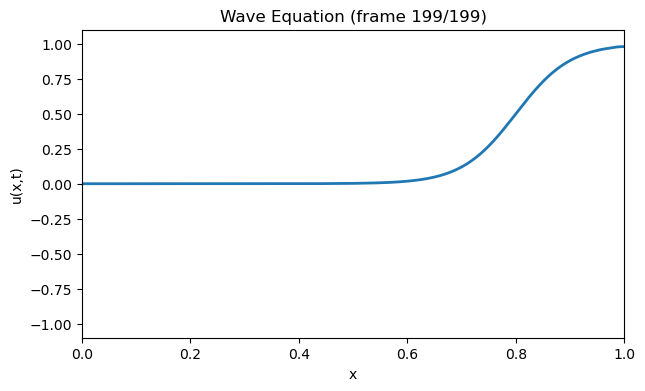

In [74]:
# Length
L = 1.0
# Mesh points
N = 500
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.0005
num_steps = 2000

c = 1.0

x0 = 0.2
alpha = 0.05  # smaller => steeper drop

# Sigmoid that is ~1 near x=0, ~0 near x=1:
#     u0 = 1 / (1 + exp((x - x0)/alpha))
u0 = 1.0 / (1.0 + np.exp( (x - x0)/alpha ))
v0 = np.zeros_like(x)

state = (u0, v0)

results = []

# plt.figure(figsize=(8,4))
# for (step, u_snapshot) in results:
#     plt.plot(x, u_snapshot, label=f"t = {step*dt:.3f}")
# plt.title("rk4 for 1d wave equation")
# plt.xlabel("x")
# plt.ylabel("u(x,t)")
# plt.legend()
# plt.show()


# 3.5. We'll store snapshots in a list for animation
snapshots = []
steps_to_store = 10  # how frequently to store frames

for step in range(num_steps):
    state = rk4_step(state, wave_equation, dt, c, dx)
    
    # store frames every 10 steps
    if step % steps_to_store == 0:
        u_snap = state[0].copy()
        snapshots.append(u_snap)

# 3.6. Create animation
fig, ax = plt.subplots(figsize=(7,4))
line, = ax.plot([], [], lw=2)

ax.set_xlim(0, L)
ax.set_ylim(-1.1, 1.1)  # adjust if needed
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("Wave Equation Evolution (RK4)")

# initialize function
def init():
    line.set_data([], [])
    return (line,)

# animation function
def animate(i):
    # i goes from 0 to len(snapshots)-1
    line.set_data(x, snapshots[i])
    ax.set_title(f"Wave Equation (frame {i}/{len(snapshots)-1})")
    return (line,)

ani = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(snapshots),
    interval=50, blit=True
)

# 3.7. Save to gif file
ani.save('wave_evolution.gif', writer='pillow', fps=20)
plt.show()

## Coupled Wave Equation
$$\frac{\partial^2 u_1}{\partial t^2} = c1^2\frac{\partial^2 u_1}{\partial x^2} + a1 \frac{\partial u_2}{\partial x} + u_2^2$$
$$\frac{\partial^2 u_2}{\partial t^2} = c2^2\frac{\partial^2 u_2}{\partial x^2} + a2 \frac{\partial u_1}{\partial x}$$

In [51]:
def coupled_wave_equations(state, c1, c2, a1, a2, b1, dx):
    u1, v1, u2, v2 = state
    N = len(u1) - 1

    du1_dt = np.zeros_like(u1)
    du2_dt = np.zeros_like(u1)
    dv1_dt = np.zeros_like(u2)
    dv2_dt = np.zeros_like(u2)

    for i in range(1, N):
        du1_dt[i] = v1[i]
        # dv1_dt[i] = (c1**2 * (u1[i+1] - 2*u1[i] + u1[i-1]) / dx**2) + a1 * (u2[i+1] - u2[i-1]) / (2 * dx)
        dv1_dt[i] = (c1**2 * (u1[i+1] - 2*u1[i] + u1[i-1]) / dx**2) + a1 * (u2[i+1] - u2[i-1]) / (2 * dx) + b1*u2[i]**2

        du2_dt[i] = v2[i]
        dv2_dt[i] = (c2**2 * (u2[i+1] - 2*u2[i] + u2[i-1]) / dx**2) + a2 * (u1[i+1] - u1[i-1]) / (2 * dx)
    
    du1_dt[0] = 0
    dv1_dt[0] = 0
    du2_dt[0] = 0
    dv2_dt[0] = 0
    du1_dt[N] = 0
    dv1_dt[N] = 0
    du2_dt[N] = 0
    dv2_dt[N] = 0

    return (du1_dt, dv1_dt, du2_dt, dv2_dt)

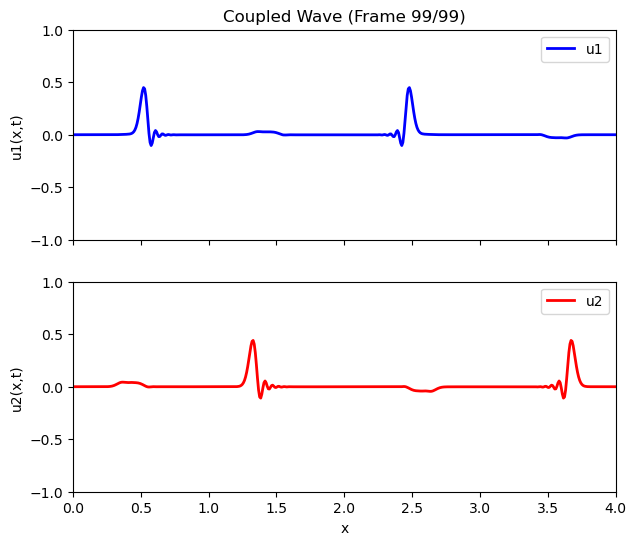

In [52]:
L = 4.0
N = 500
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.0005
num_steps = 2000

c1, c2 = 1.0, 1.2
a1, a2 = 0.5, 0.7
b1 = 100.0

# 4) 初始条件：给一个高斯脉冲在 u1 上；u2 可设为另一脉冲或全 0
#    并且初始速度均为 0。
sigma = 0.02
x0_1 = 1.5   # u1 的脉冲中心
x0_2 = 2.5   # u2 的脉冲中心(可改成相同/不同)

u1_0 = np.exp( -((x - x0_1)**2)/(2*sigma**2) )
u2_0 = np.exp( -((x - x0_2)**2)/(2*sigma**2) )
# u2_0= np.zeros_like(u1_0)

v1_0 = np.zeros_like(x)
v2_0 = np.zeros_like(x)

state = (u1_0, v1_0, u2_0, v2_0)

store_interval = 200
results = []

# 3.5. We'll store snapshots for animation
snapshots_u1 = []
snapshots_u2 = []

# how often to store frames
store_interval = 20

for step in range(num_steps):
    # Evolve one step with RK4
    state = rk4_step(state, coupled_wave_equations, dt, c1, c2, a1, a2, b1, dx)
    
    # Save frames periodically
    if step % store_interval == 0:
        (u1_snap, v1_snap, u2_snap, v2_snap) = state
        snapshots_u1.append(u1_snap.copy())
        snapshots_u2.append(u2_snap.copy())

# 3.6. Build the animation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,6), sharex=True)

# line objects for u1, u2
line1, = ax1.plot([], [], 'b-', lw=2, label="u1")
line2, = ax2.plot([], [], 'r-', lw=2, label="u2")

# Basic axis limits
ax1.set_xlim(0, L)
ax1.set_ylim(-1.0, 1.0)
ax2.set_xlim(0, L)
ax2.set_ylim(-1.0, 1.0)

ax1.set_ylabel("u1(x,t)")
ax2.set_ylabel("u2(x,t)")
ax2.set_xlabel("x")

ax1.set_title("Coupled Wave Equation: u1 & u2 evolution")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")

# init function
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return (line1, line2)

# animation update
def animate(frame_idx):
    line1.set_data(x, snapshots_u1[frame_idx])
    line2.set_data(x, snapshots_u2[frame_idx])
    ax1.set_title(f"Coupled Wave (Frame {frame_idx}/{len(snapshots_u1)-1})")
    return (line1, line2)

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(snapshots_u1), interval=50, blit=True
)

# 3.7. Save to GIF
ani.save("coupled_wave_u2_square.gif", writer='pillow', fps=20)

plt.show()